In [176]:
from collections import Counter
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from mlresearch.utils import set_matplotlib_style, parallel_loop
from mlresearch.utils._check_pipelines import check_random_states
from recgame.environments import BaseEnvironment

set_matplotlib_style(32, **{"font.family":"Times"})

# NFeatureRecourse ignoring categorical feature

In [2]:
import warnings
from typing import Union
import numpy as np
from recgame.recourse.base import BaseRecourse


class NFeatureRecourse(BaseRecourse):
    """TODO: Add documentation."""

    def __init__(
        self,
        model,
        n_features: int = None,
        threshold=0.5,
        categorical: Union[list, np.ndarray] = None,
        immutable: Union[list, np.ndarray] = None,
        step_direction: dict = None,
        y_desired: Union[int, str] = 1,
    ):
        super().__init__(
            model=model,
            threshold=threshold,
            categorical=categorical,
            immutable=immutable,
            step_direction=step_direction,
            y_desired=y_desired,
        )

        # if categorical is not None and categorical != []:
        #     raise TypeError(
        #         "NFeatureRecourse does not work with categorical features. Consider "
        #         "using a different recourse method."
        #     )

        self.n_features = n_features

    def _counterfactual(self, agent, action_set):
        agent_original = agent.copy()

        # Do not change if the agent is over the threshold
        if self.model.predict_proba(agent.to_frame().T)[0, -1] >= self.threshold:
            return agent_original

        categorical_vals = agent_original[self.categorical].values
        agent = agent_original.drop(self.categorical).copy()

        intercept, coefficients, model = self._get_coefficients()

        # Get base vector
        base_vector = coefficients.copy().squeeze()
        n_features = (
            base_vector.shape[0] if self.n_features is None else self.n_features
        )

        is_usable = np.array(
            [
                action_set[col].step_direction in [np.sign(coeff), 0]
                and action_set[col].actionable
                for col, coeff in zip(agent.index, base_vector)
            ]
        )
        base_vector[~is_usable] = 0

        # Use features with highest contribution towards the threshold
        rejected_features = np.argsort(np.abs(base_vector))[:-n_features]
        base_vector[rejected_features] = 0

        base_vector = base_vector / np.linalg.norm(base_vector)
        multiplier = (-intercept - np.dot(agent.values, coefficients.T)) / np.dot(
            base_vector, coefficients.T
        )
        counterfactual = agent + multiplier * base_vector
                        
        lb, ub = np.array(action_set.lb), np.array(action_set.ub)
        
        lb = lb[action_set.df.name.values != self.categorical]
        ub = ub[action_set.df.name.values != self.categorical]

        # Check if base_vector adjustments are not generating invalid counterfactuals
        for i in range(agent.shape[0]):
            # Adjust vector according to features' bounds
            lb_valid = counterfactual >= lb
            ub_valid = counterfactual <= ub

            if lb_valid.all() and ub_valid.all():
                break

            if not lb_valid.all():
                # Fix values to its lower bound
                idx = np.where(~lb_valid)[0]
                agent[idx] = lb[idx]
                base_vector[idx] = 0

            if not ub_valid.all():
                # Fix values to its upper bound
                idx = np.where(~ub_valid)[0]
                agent[idx] = ub[idx]
                base_vector[idx] = 0

            if (base_vector == 0).all():
                # All max/min boundaries have been met.
                counterfactual = agent
            else:
                
                # Redefine counterfactual after adjusting the base vector
                base_vector = base_vector / np.linalg.norm(base_vector)
                multiplier = (
                    -intercept - np.dot(agent.values, coefficients.T)
                ) / np.dot(base_vector, coefficients.T)
                counterfactual = agent + multiplier * base_vector

        lb_valid = counterfactual >= lb
        ub_valid = counterfactual <= ub
        if not (lb_valid.all() and ub_valid.all()):
            warnings.warn(
                "Could not generate a counterfactual to reach the desired threshold."
            )

            
        for cat_feat, value in zip(self.categorical, categorical_vals):
            counterfactual[cat_feat] = value


        return counterfactual


# Define functions

In [3]:
def get_scaler(n_agents=10_000, n_continuous=2, bias_factor=0, mean=0, std=1/4, random_state=None):
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]
    
    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=mean, scale=std, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=mean+bias_factor*std, scale=std, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    return MinMaxScaler().fit(X)


In [4]:
def biased_data_generator(n_agents, n_continuous=2, bias_factor=0, mean=0, std=1/4, scaler=None, random_state=None):
    """
    groups feature: 
    - 0 -> Disadvantaged group
    - 1 -> Advantaged group
    
    ``bias_factor`` varies between [0, 1], 0 is completely unbiased, 1 is fully biased.
    """
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]

    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=mean, scale=std, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=mean+bias_factor*std, scale=std, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    
    # TEST: scale continuous features
    if scaler is not None:
        X.loc[:,:] = scaler.transform(X)
    
    X = pd.concat([X, groups], axis=1)
    X = np.clip(X, 0, 1)
    
    # Generate the target
    p0 = 1 / (2 + 2*bias_factor)
    p1 = 1 - p0

    y0 = rng.binomial(1, p0, counts[0])
    y1 = rng.binomial(1, p1, counts[1])
    
    y = pd.concat(
        [
            pd.Series((y0 if val==0 else y1), index=group.index) 
            for val, group in X.groupby("groups")
        ]
    ).sort_index()

    return X, y


In [5]:
class IgnoreGroupLR(LogisticRegression):
    def __init__(self, ignore_feature=None, **kwargs):
        super().__init__(**kwargs)
        self.ignore_feature = ignore_feature
    
    def _get_X(self, X):
        return X.copy() if self.ignore_feature is None else X.drop(columns=self.ignore_feature)
    
    def fit(self, X, y):
        """NOTE: X must be a pandas dataframe."""
        super().fit(self._get_X(X), y)
        return self

    def predict(self, X):
        return super().predict(self._get_X(X))
    
    def predict_proba(self, X):
        return super().predict_proba(self._get_X(X))

In [6]:
from recgame.environments._behavior_functions import ContinuousFlexible


class ContinuousConstantCustom(ContinuousFlexible):
    """Applies continuous adaptation with constant effort."""
    bias_factor_effort_g0 = 0
    bias_factor_effort_g1 = 0
    
    def effort(self, X, global_adaptation):
        """
        Applies constant effort.

        Returns effort rate.
        """
        # Fetch environment variables
        rng = self.environment._rng

        current_effort = (
            self.environment.effort_ if hasattr(self.environment, "effort_") else None
        )

        df_new = (
            self.environment._new_agents
            if hasattr(self.environment, "_new_agents")
            else X
        )

        counts = Counter(df_new["groups"])
        
        x0 = np.abs(rng.normal(0+self.bias_factor_effort_g0, 1, counts[0]))
        x1 = np.abs(rng.normal(0+self.bias_factor_effort_g1, 1, counts[1]))
        
        x = df_new["groups"].copy()
        x.loc[x==0] = x0
        x.loc[x==1] = x1
        x = x.values

        effort_rate = x * global_adaptation / 20
        effort_rate = pd.Series(effort_rate, index=df_new.index)
        effort_rate = pd.concat([current_effort, effort_rate])

        # return pd.Series(effort_rate, index=X.index)
        return effort_rate

    
def behavior_function_generator(bias_factor_effort_g0, bias_factor_effort_g1):
    behav = ContinuousConstantCustom
    behav.bias_factor_effort_g0 = bias_factor_effort_g0
    behav.bias_factor_effort_g1 = bias_factor_effort_g1
    return behav

In [7]:
def fairness_metrics(environment, bins=10, advantaged_pop=1):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    # Get fairness analysis
    fairness_analysis = agents_info.dropna().groupby("groups").mean()
    success_rates = environment.analysis.success_rate(filter_feature="groups")
    fairness_analysis["avg_recourse_reliability"] = success_rates.mean()

    # Get disparity metrics
    not_advantaged = fairness_analysis.index[fairness_analysis.index != advantaged_pop]
    
    if len(not_advantaged) > 1:
        raise NotImplementedError("Only two groups supported.")
    else:
        not_advantaged = not_advantaged[0]
        
    disparates = (fairness_analysis.loc[not_advantaged] / fairness_analysis.loc[advantaged_pop])
    disparates = disparates[["time_for_recourse"]]
    disparates.index = [var for var in disparates.index + "_disparity"]
    disparates["time_for_recourse_disparity"] = (
        fairness_analysis.loc[not_advantaged, "time_for_recourse"] 
        - fairness_analysis.loc[advantaged_pop, "time_for_recourse"]
    )

    # Get Equality of Opportunity
    init_scores = environment.metadata_[0]["score"]
    efforts = []
    for step in environment.metadata_.keys():
        if step == 0:
            continue
            
        eff = (
            environment.outcome(step=step, return_scores=True)[-1]
            - environment.outcome(step=step-1, return_scores=True)[-1]
        )
        eff = eff[eff.index.isin(environment.metadata_[step]["X"].index)]
        eff.fillna(0, inplace=True)
        
        efforts.append((step, eff))

    
    # Used to get the features to calculate EO
    def extract_info(df):
        avg_effort = df["effort"].mean()    
        outcome_rate = df["outcome"].sum() / df.shape[0]
        return pd.Series({"avg_effort": avg_effort, "outcome_rate": outcome_rate})

    eo_per_step = []
    for step, effort in efforts:
        ai_step = agents_info.copy()
        ai_step["effort"] = effort
        ai_step.dropna(subset="effort", inplace=True)    
        ai_step["effort_bins"] = pd.cut(ai_step["effort"], bins)
        ai_step["outcome"] = environment.metadata_[step]["outcome"]
        
        eo = ai_step.groupby(["groups", "effort_bins"], group_keys=True).apply(extract_info)
        eo = eo.reset_index().groupby("groups", group_keys=True).apply(lambda df: (df["outcome_rate"] * df["avg_effort"]).sum() / df["avg_effort"].sum())
        eo = eo.to_frame(step).T
        eo["eo_total"] = eo[not_advantaged] / eo[advantaged_pop]
        eo_per_step.append(eo)
    
    eo_per_step = pd.concat(eo_per_step)
    
    disparates["avg_EO"] = eo_per_step["eo_total"].mean()
    
    if return_eo_only:
        return eo_per_step
    
    return disparates

In [8]:
def fairness_metrics_per_time_step(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    # Get fairness analysis
    fairness_analysis = agents_info.dropna().groupby("groups").mean()
    success_rates = environment.analysis.success_rate(filter_feature="groups")
    sns.lineplot(success_rates)

In [9]:
def fairness_metrics_overall_visualizations(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    results = {}
    
    # ETR - Effort to recourse
    ai_etr = agents_info.dropna(subset="favorable_step")
    ai_etr = ai_etr[ai_etr["n_adaptations"]!=0]

    ai_etr["total_effort"] = ai_etr["final_score"] - ai_etr["original_score"]
    etr = ai_etr.groupby("groups").mean()["total_effort"]
    results["etr_disparity"] = etr.loc[0] / etr.loc[1]    
    
    # TTR
    ttr = ai_etr.groupby("groups").mean()["time_for_recourse"]
    results["disparate_ttr"] = ttr.loc[0] - ttr.loc[1]

    sns.boxplot(data=ai_etr, x="groups", y="total_effort")
    plt.show()
    
    sns.boxplot(data=ai_etr, x="groups", y="time_for_recourse")
    plt.show()

    return results


In [10]:
def fairness_metrics_overall(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    results = {}
    
    # ETR - Effort to recourse
    ai_etr = agents_info.dropna(subset="favorable_step")
    ai_etr = ai_etr[ai_etr["n_adaptations"]!=0]

    ai_etr["total_effort"] = ai_etr["final_score"] - ai_etr["original_score"]
    etr = ai_etr.groupby("groups").mean()["total_effort"]
    results["etr_disparity"] = etr.loc[0] / etr.loc[1]    
    
    # TTR
    ttr = ai_etr.groupby("groups").mean()["time_for_recourse"]
    results["disparate_ttr"] = ttr.loc[0] - ttr.loc[1]
    
    return results


In [11]:
def fairness_metrics_viz_data(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    results = {}
    
    # ETR - Effort to recourse
    ai_etr = agents_info.dropna(subset="favorable_step")
    ai_etr = ai_etr[ai_etr["n_adaptations"]!=0]

    ai_etr["total_effort"] = ai_etr["final_score"] - ai_etr["original_score"]
    etr = ai_etr.groupby("groups").mean()["total_effort"]
    results["etr_disparity"] = etr.loc[0] / etr.loc[1]    
    
    # TTR
    ttr = ai_etr.groupby("groups").mean()["time_for_recourse"]
    results["disparate_ttr"] = ttr.loc[0] - ttr.loc[1]

    return ai_etr


In [12]:
def _meta_simulation(params):
    """
    N_AGENTS
    N_CONTINUOUS
    N_LOANS
    BIAS_FACTOR
    ADAPTATION
    NEW_AGENTS
    RNG_SEED
    """ 
    N_AGENTS, N_CONTINUOUS, N_LOANS, BIAS_FACTOR, ADAPTATION, NEW_AGENTS, BIAS_EFFORT, RNG_SEED = params
    
    rng = np.random.default_rng(RNG_SEED)
    
    scaler = get_scaler(
        n_agents=10_000, 
        n_continuous=N_CONTINUOUS, 
        bias_factor=BIAS_FACTOR, 
        random_state=rng
    )

    def env_biased_data_generator(n_agents):
        return biased_data_generator(n_agents, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)[0]
    
    df, y = biased_data_generator(N_AGENTS, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)
    categorical = ["groups"]
    
    model = IgnoreGroupLR(categorical, random_state=RNG_SEED).fit(df, y)
    
    model.coef_ = np.array([[2, 2]])
    model.intercept_ = np.array([-1])
    
    # Define the necessary components to run simulation
    recourse = NFeatureRecourse(model, categorical=["groups"], immutable=["groups"])  # , random_state=RNG_SEED)
    recourse.set_actions(df)
    recourse.action_set_.lb = [-0.1, -0.1, 0]
    recourse.action_set_.ub = [1.1, 1.1, 1]
    
    environment = BaseEnvironment(
        X=df,
        recourse=recourse,
        data_source_func=env_biased_data_generator,
        threshold=N_LOANS,
        threshold_type="absolute",
        adaptation=ADAPTATION,
        behavior_function=behavior_function_generator(*BIAS_EFFORT),
        growth_rate=NEW_AGENTS,
        growth_rate_type="absolute",
        random_state=RNG_SEED,
    )
    
    try:
        environment.simulate(20)
        return (
            {
                "N_AGENTS": N_AGENTS,
                "N_CONTINUOUS": N_CONTINUOUS,
                "N_LOANS": N_LOANS,
                "BIAS_FACTOR": BIAS_FACTOR,
                "ADAPTATION": ADAPTATION,
                "NEW_AGENTS": NEW_AGENTS,
                "BIAS_EFFORT": BIAS_EFFORT,
                "RNG_SEED": RNG_SEED,
    
            }, 
            environment,
        )
    except:
        print(f"Experiment failed with params {params}\nRetrying with a new random seed.")
        params["RNG_SEED"] = params["RNG_SEED"]+1
        return _meta_simulation(params)
    


# Experiments

In [13]:
N_AGENTS = [100]
N_CONTINUOUS = [2]
N_LOANS = [10]
BIAS_FACTOR = [0,1,2,3]
ADAPTATION = [.5]
NEW_AGENTS = [10]
RNG_SEED = check_random_states(42, 5)
BIAS_EFFORT = ([1, 0],)

# EXP 1

In [14]:
results = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

Output()

In [15]:
# fair_res = []
# for hyperparams, environment in results:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

In [16]:
# pd.DataFrame(np.mean(ai_etrs, axis=0), columns=ai_etrs[0].columns, index=ai_etrs[0].index)

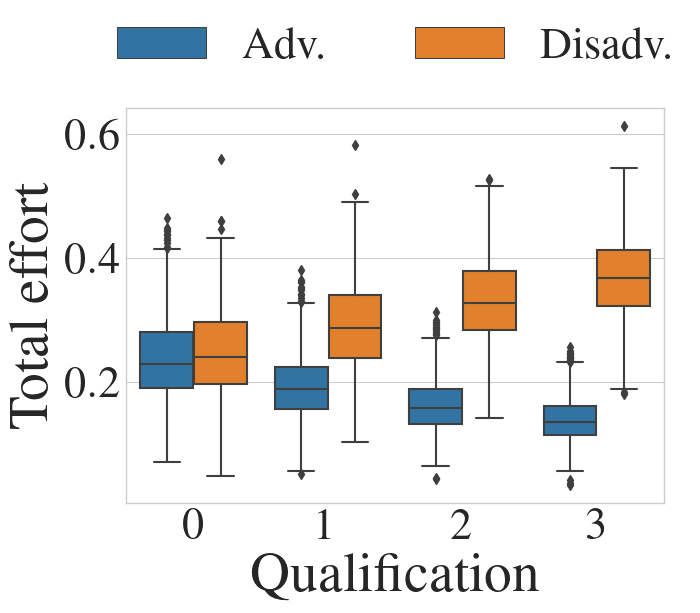

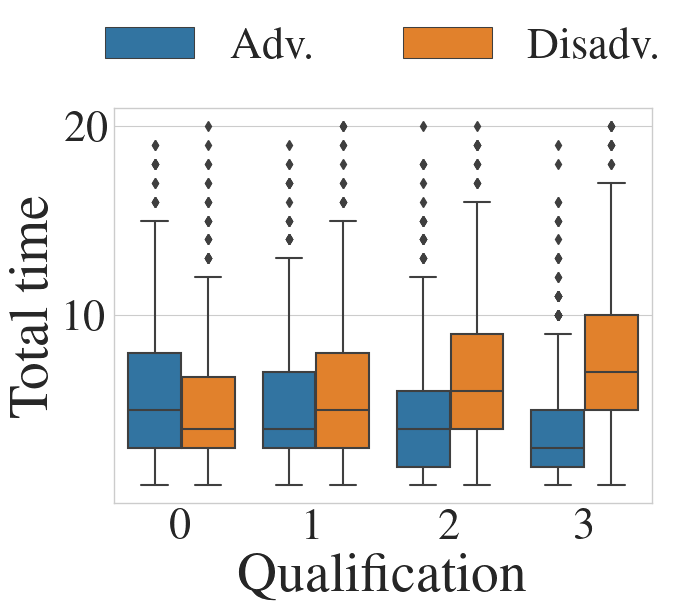

In [211]:
metrics_dfs = []
for params, environment in results:
    ai_etr = fairness_metrics_viz_data(environment)
    ai_etr["rng_seed"] = params["RNG_SEED"]
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")
ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"B10_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")
ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"B10_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [212]:
agents_outcome

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures,groups,time_for_recourse,total_effort,qualification,groups2
116,2,18,20.0,0.725850,0.967705,0,1,18.0,0.241854,1,Adv.
157,6,14,20.0,0.693617,0.967705,0,1,14.0,0.274087,1,Adv.
205,11,9,20.0,0.678633,0.967705,0,0,9.0,0.289072,1,Disadv.
214,12,8,20.0,0.769786,0.967705,0,1,8.0,0.197919,1,Adv.
256,16,4,20.0,0.766656,0.967705,0,1,4.0,0.201048,1,Adv.
260,17,3,20.0,0.734615,0.967705,0,0,3.0,0.233090,1,Disadv.
264,17,3,20.0,0.802872,0.967705,0,1,3.0,0.164833,1,Adv.
270,18,2,20.0,0.799951,0.967705,0,0,2.0,0.167754,1,Disadv.
274,18,2,20.0,0.882114,0.967705,0,1,2.0,0.085591,1,Adv.
276,18,2,20.0,0.704467,0.957753,0,0,2.0,0.253286,1,Disadv.


groups2,favorable_step,Adv.,Disadv.
0,1.0,0.181237,0.188714
1,2.0,0.179375,0.273235
2,3.0,0.217614,0.296169
3,4.0,0.169498,0.268315
4,5.0,0.197681,0.294507
...,...,...,...
95,16.0,0.243814,0.285476
96,17.0,0.151735,0.281367
97,18.0,0.174718,0.314049
98,19.0,0.174170,0.292434


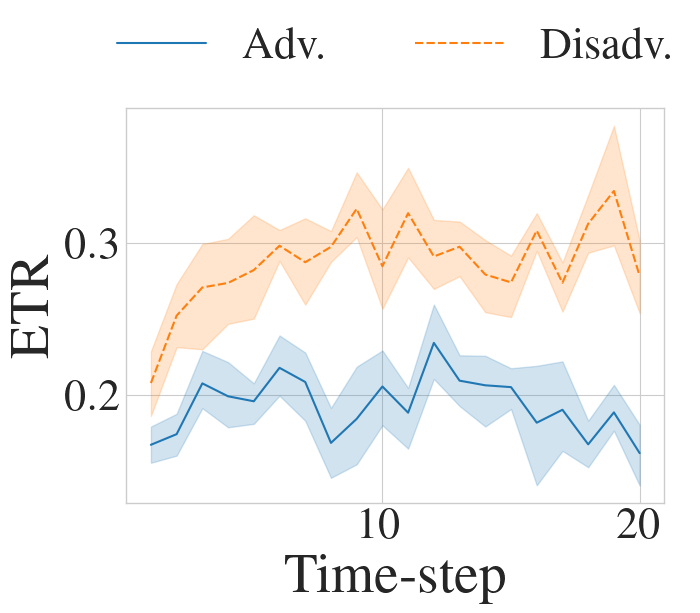

In [230]:
QUALIFICATION = 1

adnr = agents_data_n_runs[agents_data_n_runs.qualification == QUALIFICATION]

data = (
    adnr
    .groupby(["rng_seed", "favorable_step", "groups2"])["total_effort"]
    .mean()
    .reset_index()
    .pivot(index=["rng_seed", "favorable_step"] , columns="groups2", values="total_effort")
    .reset_index()
    .drop(columns="rng_seed")
    .set_index("favorable_step")
)

ax = sns.lineplot(data)
ax.set_xlabel("Time-step")
ax.set_ylabel("ETR")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"Q1_ETR_over_time.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [18]:
m1 = agents_data_n_runs.groupby(["qualification", "groups"]).mean(numeric_only=True)[["time_for_recourse", "total_effort"]]

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

m1.reset_index().groupby("qualification").apply(apply_transf)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,-0.972114,1.036997
1,1.084367,1.502884
2,2.546835,2.043700
3,3.695770,2.635850


# EXP 2

In [19]:
BIAS_EFFORT2 = ([0, 1],) # [0, 0], 

In [20]:
results2 = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT2,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

Output()

In [21]:
# fair_res = []
# for hyperparams, environment in results2:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

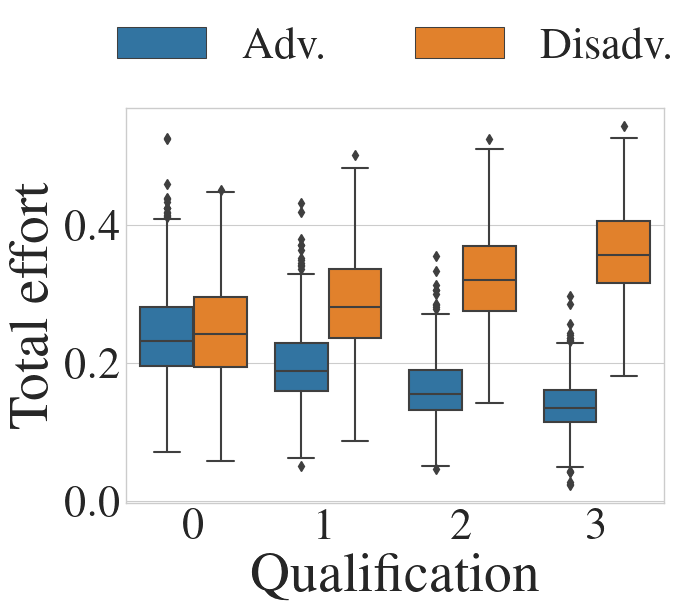

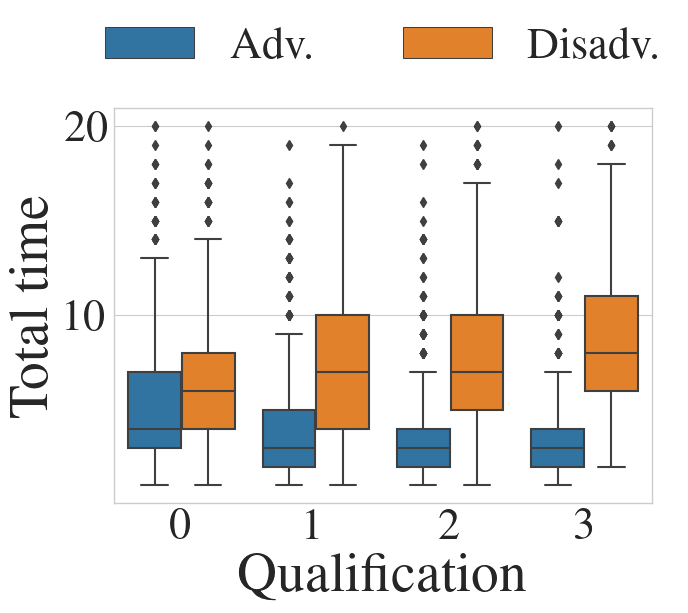

In [190]:
metrics_dfs = []
for params, environment in results2:
    ai_etr = fairness_metrics_viz_data(environment)
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")        
ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"B01_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")
ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"B01_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [23]:
m2 = agents_data_n_runs.groupby(["qualification", "groups"]).mean(numeric_only=True)[["time_for_recourse", "total_effort"]]

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

m2.reset_index().groupby("qualification").apply(apply_transf)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,1.196621,1.014982
1,3.230735,1.464626
2,4.481221,2.012873
3,5.585883,2.614203


# EXP 3

In [24]:
BIAS_EFFORT3 = ([0, 0],)

In [25]:
results3 = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT3,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

Output()

In [26]:
# fair_res = []
# for hyperparams, environment in results:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

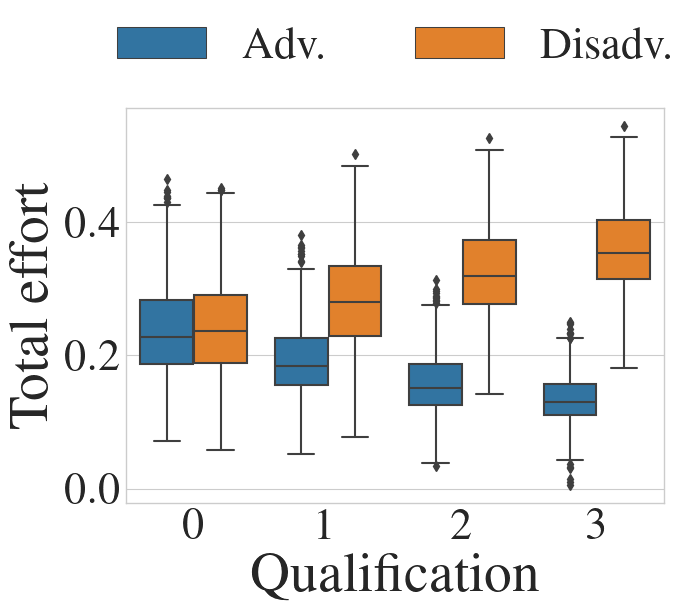

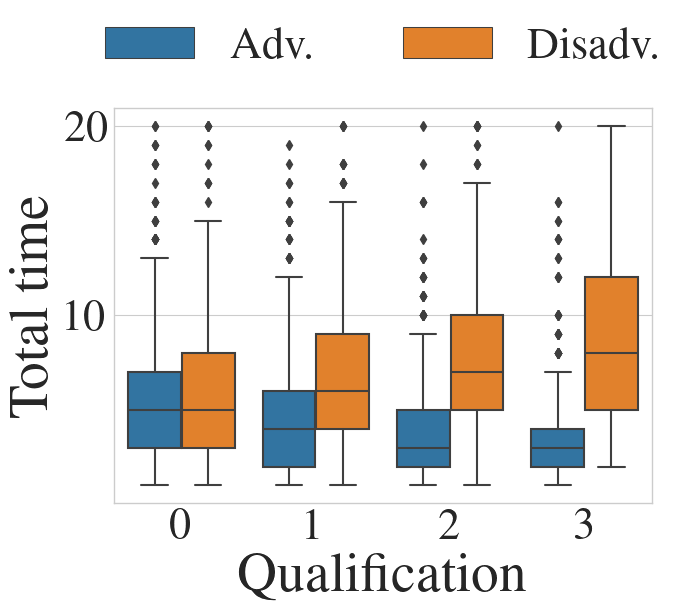

In [42]:
metrics_dfs = []
for params, environment in results3:
    ai_etr = fairness_metrics_viz_data(environment)
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")
ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"B00_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")
ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"B00_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()


In [28]:
m3 = agents_data_n_runs.groupby(["qualification", "groups"]).mean(numeric_only=True)[["time_for_recourse", "total_effort"]]

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

m3.reset_index().groupby("qualification").apply(apply_transf)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,0.334181,1.025824
1,2.345805,1.492017
2,4.092800,2.056097
3,5.377491,2.688003


# 1st PAGE VIZ - TESTS

In [159]:
QUALIFICATION = 1

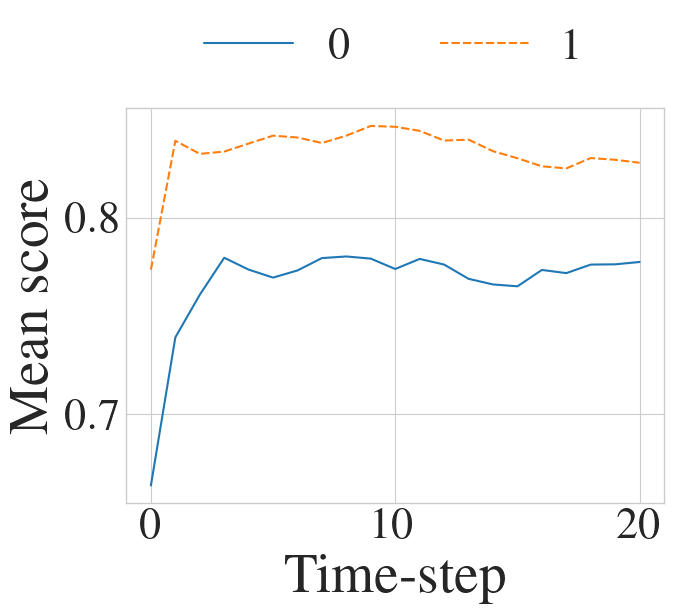

In [167]:
scores_dfs = []
for params, environment in results:
    if params["BIAS_FACTOR"] == QUALIFICATION:
        scores = [ 
            pd.concat(
                [
                    environment.metadata_[step]["score"].rename("score"), 
                    environment.metadata_[step]["X"]["groups"],
                    pd.Series(np.ones(environment.metadata_[step]["score"].shape), name="step") * step
                ], 
                axis=1
            ).groupby("groups").mean()
            for step in environment.metadata_.keys()
        ]
        
        scores = pd.concat(scores).reset_index()
        scores["groups"] = scores["groups"].astype(int)
        scores["step"] = scores["step"].astype(int)
        scores = scores.pivot(index="step", columns="groups", values="score").reset_index()
        scores.columns.rename(None, inplace=True)
        scores_dfs.append(scores)
        
scores_dfs_exp1 = pd.DataFrame(np.mean(scores_dfs, axis=0), columns=scores_dfs[0].columns, index=scores_dfs[0].index)
scores_dfs_exp1["step"] = scores_dfs_exp1["step"].astype(int)
scores_dfs_exp1 = scores_dfs_exp1.set_index("step")
ax = sns.lineplot(scores_dfs_exp1)
ax.set_xlabel("Time-step")
ax.set_ylabel("Mean score")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

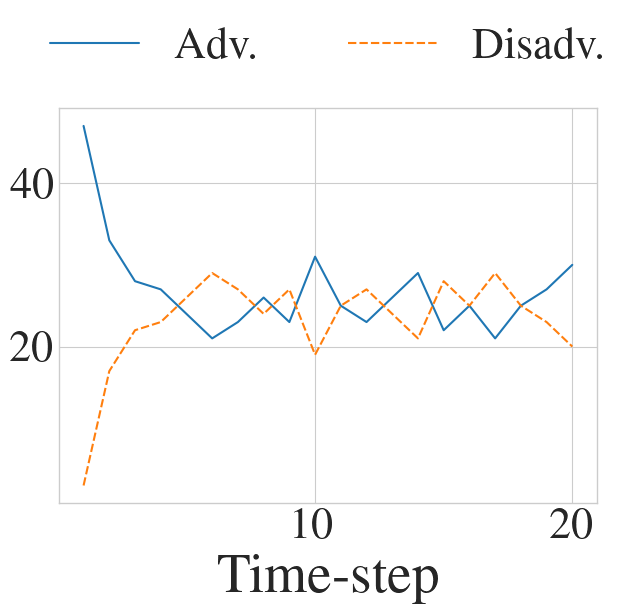

In [169]:
QUALIFICATION = 2

adnr = agents_data_n_runs[agents_data_n_runs.qualification == QUALIFICATION]

steps_data = []
for step in range(int(adnr.favorable_step.max()+1)):
    agents_outcome = adnr[adnr["favorable_step"].astype(int) == step]
    etr = agents_outcome.groupby("groups2").size()
    etr.name = step
    steps_data.append(etr)
    
steps_data = pd.concat(steps_data, axis=1).T
steps_data.columns.rename(None, inplace=True)
ax = sns.lineplot(steps_data)
ax.set_xlabel("Time-step")
ax.set_ylabel("")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)